In [265]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import norm

In [266]:
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.distributions.normal as normal_distribution
import torch
import math

In [267]:
from data.catalog import DataCatalog
from models.catalog import MLModelCatalog
from torch import nn
softmax = nn.Softmax()

In [268]:
## for Palatino and other serif fonts use:
import seaborn as sns
sns.set_theme(style="whitegrid")
#sns.set_context(font_scale=1.6)
viz_dict = {
    "font.size": 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    "legend.fontsize": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
} 
sns.set_context("notebook", rc=viz_dict)
import matplotlib.pyplot as plt
from matplotlib import rc

font = {'family': 'serif',
        'weight': 'bold',
        'serif': ['Palatino'],
        'size': 20}
rc('font', **font)
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['axes.autolimit_mode']

C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


'data'

In [269]:
def gaussian_pdf(mean, var):
    pi = torch.tensor(math.pi)
    pdf = 1/(torch.sqrt(2*pi)) * torch.exp(- 0.5 * torch.divide( torch.square(-mean), var) )
    return pdf

In [270]:
current_dir = os.getcwd()
current_dir  = current_dir + '/recourse_invalidation_results/experiment_09_01_22/'

In [271]:
# Need to be in "C:\\Users\\fred0\\Documents\\project_robust_explanations\\RobustExplanations\\carla'

In [272]:
training_params_linear = {
    "adult": {"lr": 0.002, "epochs": 100, "batch_size": 1024},
    "compas": {"lr": 0.002, "epochs": 25, "batch_size": 128},
    "give_me_some_credit": {"lr": 0.002, "epochs": 50, "batch_size": 2048},
}
training_params_ann = {
    "adult": {"lr": 0.002, "epochs": 30, "batch_size": 1024},
    "compas": {"lr": 0.002, "epochs": 25, "batch_size": 25},
    "give_me_some_credit": {"lr": 0.002, "epochs": 50, "batch_size": 2048},
}
training_params = {"linear": training_params_linear, "ann": training_params_ann}

In [273]:
def compute_jacobian(inputs, output, num_classes=1):
    """
    :param inputs: Batch X Size (e.g. Depth X Width X Height)
    :param output: Batch X Classes
    :return: jacobian: Batch X Classes X Size
    """
    assert inputs.requires_grad
    
    jacobian = torch.zeros(num_classes, *inputs.size())
    grad_output = torch.zeros(*output.size())
    
    grad_output.zero_()
    grad_output[0] = 1
    output.backward(grad_output)
    jacobian = inputs.grad.data
    
    return jacobian

In [274]:
def get_lastlayer_weight(model, intercept=False) -> torch.tensor:
    
    # LAST LAYER
    last_layer = model.raw_model.layers[-1]
    last_layer_weights = last_layer.weight.squeeze()
    last_layer_biases = last_layer.bias.squeeze()
    
    # get weights and bias of layer for negative class 0
    coeffs_neg = last_layer_weights[0]
    intercepts_neg = last_layer_biases[0]

    # get weights and bias of linear layer for positive class 1
    coeffs_pos = last_layer_weights[1]
    intercepts_pos = last_layer_biases[1]

    coeffs = -(coeffs_neg - coeffs_pos)
    if intercept:
        intercepts = -(intercepts_neg - intercepts_pos)
        return coeffs, intercept
    else:
        return coeffs

In [275]:
# This function obtains the weights from the ANN model
def get_constant_and_jacobian(model, sigma2, x, cf) -> np.array:
    
    #print(sigma2)    
    sigma = np.sqrt(np.array(sigma2))
    
    # get CF logit
    x = torch.tensor(x).float()
    cf = torch.tensor(cf).float()
    prob = softmax(model.raw_model(x))
    #print('prob', prob)
    logit_x = torch.log(prob[1]/prob[0]).detach().numpy()
    #print('logit', logit_x)

    # get jacobian at factual
    fixed_x_tensor = torch.autograd.Variable(x.clone(), requires_grad=True)
    output_f_tensor = model.raw_model(fixed_x_tensor)
    jacobian_x = compute_jacobian(fixed_x_tensor, output_f_tensor, num_classes=1).detach().numpy()
    
    # get jacobian at counterfactual
    fixed_cf_tensor = torch.autograd.Variable(cf.clone(), requires_grad=True)
    output_cf_tensor = model.raw_model(fixed_cf_tensor)
    jacobian_cf = compute_jacobian(fixed_cf_tensor, output_cf_tensor, num_classes=1).detach().numpy()

    jacobian_norm_cf = np.linalg.norm(jacobian_cf, ord=2)
    constant_prime = logit_x / (jacobian_norm_cf * sigma)
    
    return constant_prime, jacobian_x, jacobian_cf

def get_omega(weight: np.array, action: np.array) -> np.array:
    # This function computes the cosine of the angle
    dot_product = np.dot(weight, action)
    norm_action = np.linalg.norm(action, ord=2)
    norm_weight = np.linalg.norm(weight, ord=2)
    omega = dot_product / (norm_action * norm_weight)
    return omega

def get_norms(action: np.array) -> np.array:
    norm_inf = np.linalg.norm(action, np.inf)
    norm_zero = np.linalg.norm(action, ord=0)
    norm_one = np.linalg.norm(action, ord=1)
    return norm_zero, norm_one, norm_inf

def compute_upper_bound(model, factual: np.array, cf:np.array, action: np.array, sigma2: float) -> np.array:
    constant, jacobian_x, jacobian_cf = get_constant_and_jacobian(model, sigma2, factual, cf) 
    omega = get_omega(jacobian_x, action)
    
    action_norm_zero, action_norm_one, action_norm_inf = get_norms(action)
    
    norm_jac_x = np.linalg.norm(jacobian_x, ord=2)
    norm_jac_cf = np.linalg.norm(jacobian_cf, ord=2)
    
    y = constant + (omega/np.sqrt(sigma2)) * (norm_jac_x/norm_jac_cf) * (action_norm_one / np.sqrt(action_norm_zero))
    
    cdf = norm.cdf(y)
    lower_bound = 1 - cdf
    return lower_bound

ann_layers_50
Loaded model from C:\Users\fred0\carla\models\adult\ann_layers_50.pt
approx. acc: 0.8352719528178244
ar
adult
wachter
adult


C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


gs
adult
dice
adult
roar
adult
arar
adult
wachter_rip
adult
ann_layers_50
Loaded model from C:\Users\fred0\carla\models\compas\ann_layers_50.pt
approx. acc: 0.8230719377835386
ar
compas
wachter
compas
gs
compas
dice
compas


C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


roar
compas
arar
compas
wachter_rip
compas
ann_layers_50
Loaded model from C:\Users\fred0\carla\models\give_me_some_credit\ann_layers_50.pt
approx. acc: 0.9286406758534728
ar
give_me_some_credit
wachter
give_me_some_credit
gs
give_me_some_credit


C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\fred0\Anaconda3\envs\env_robustnes\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


dice
give_me_some_credit
roar
give_me_some_credit
arar
give_me_some_credit
wachter_rip
give_me_some_credit


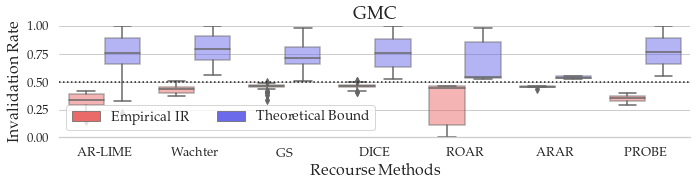

In [276]:
# color = 'nipy_spectral_r'
color = 'seismic_r'
alpha = 0.5
intarget = "0.3"
model_type = "ann"
sigma2 = "0.01"
backend = "pytorch"
widths = ["50"]

for width in widths:

    if width == "50":
        hidden_width = [50]
    elif width == "100":
        hidden_width = [100]
    elif width == "1000":
        hidden_width = [1000]

    model_names = ['ar', 'wachter', 'gs', 'dice', 'roar', 'arar', 'wachter_rip']
    model_names_plot = ['AR-LIME', 'Wachter', 'GS', 'DICE', 'ROAR', 'ARAR', 'PROBE']
    data_names = ["adult", "compas", "give_me_some_credit"]
    data_names_plot = ["Adult", "Compas" , "GMC"]

    for data_name in data_names:
        plt.close('all')
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))

        params = training_params[model_type][data_name]
        data = DataCatalog(data_name)
        model = MLModelCatalog(
            data, model_type, load_online=False, use_pipeline=True, backend=backend
        )
        model.train(
            learning_rate=params["lr"],
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            hidden_size=hidden_width,
        )
        model.use_pipeline = False

        ph1 = [] 
        ph2 = []
        ph3 = []

        if data_name == 'adult':
            data_plot_name = 'Adult'
        elif data_name == 'compas':
            data_plot_name = 'Compas'   
        elif data_name == 'give_me_some_credit':
            data_plot_name = 'GMC'

        jt = 0
        for model_name in model_names:
            print(model_name)
            print(data_name)

            if model_name == 'wachter_rip':
                intarget = "0.35"
            else:
                intarget = "0.5"

            # identify values for which no CE could be found!
            df2 = pd.read_csv(current_dir + '/' + model_name + '_' + data_name + '_' + model_type + '_' + width + '_sigma2_' + sigma2 + '_intarget_' + intarget + '/counterfactual.csv')
            df1 = pd.read_csv(current_dir + '/' + model_name + '_' + data_name + '_' + model_type + '_' + width + '_sigma2_' + sigma2 + '_intarget_' + intarget + '/factual.csv')
            df1 = df1.drop(columns=['prediction'])
            ce_class = df2['prediction'].values
            ce_class_idx = np.where(ce_class==1)[0]
            df2 = df2.drop(columns=['prediction'])
            df = pd.read_csv(current_dir + '/' + model_name + '_'+ data_name + '_' + model_type + '_' + width + '_sigma2_' + sigma2 + '_intarget_' + intarget + '/delta.csv')

            rips = df.values[ce_class_idx]
            actions = df2.values[ce_class_idx] - df1.values[ce_class_idx]
            x = df1.values[ce_class_idx]
            cfs = df2.values[ce_class_idx]
    
            n_samples = x.shape[0] 
            uppers = []
            lowers = []
            probs = []

            for it in range(n_samples):
                sig2 = float(sigma2)
                sigma = np.sqrt(sig2)
                factual = x[it]
                action = actions[it]
                cf = cfs[it]
                rip = rips[it][0]
                
                # Compute upper bounds
                upper = compute_upper_bound(model, factual, cf, action, sig2)
                uppers.append(np.round(upper, 2))
                probs.append(np.round(rip, 2))

            ph1 = ph1 + probs + uppers
            n_samples = len(probs)

            upper_names = list(np.repeat('Theoretical Bound', n_samples).reshape(-1, 1))
            rip_names = list(np.repeat('Empirical IR', n_samples).reshape(-1, 1))
            ph2 = ph2 + rip_names + upper_names 

            method_name = list(np.repeat(model_names_plot[jt], n_samples*2))
            ph3 = ph3 + method_name

            jt += 1

        dframe = np.c_[ph1, ph2, ph3]
        dframe = pd.DataFrame(dframe)
        dframe.columns = ['Invalidation Rate', 'Type', 'Recourse Methods']
        dframe["Invalidation Rate"] = pd.to_numeric(dframe["Invalidation Rate"])

        f = sns.boxplot(y="Invalidation Rate", x="Recourse Methods", hue="Type", 
                        data=dframe, ax=ax, palette=color, boxprops=dict(alpha=alpha))    
        f.legend(ncol=2, loc=3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.axhline(0.5, linestyle='dotted', label='Base', color='k')
        ax.set_ylim([0,1])
        ax.set_title(data_plot_name)

        fig.tight_layout()
        fig.savefig(current_dir + '/' + 'bounds_' + data_name +  '_' + "all_"+ model_type  +"_models" + '_' + 'width_' + width + '_sigma2_' + sigma2 + '.pdf')